# Requirements

- Python 3.6.2 (NOT python 3.7)
- Sign up for an Intrinio account at https://intrinio.com/ and obtain an API key. Subscription to the 'US Fundamentals and Stock Prices' subscription (free, trial or paid) is required.

Python libaries:
- TensorFlow r1.13 
- keras
- requests
- pandas
- matplotlib
- seaborn

# A deep learning price prediction model with TensorFlow

## Download the dataset

In [4]:
import requests

BASE_URL = 'https://api-v2.intrinio.com'

# REPLACE YOUR INTRINIO API KEY HERE!
INTRINIO_API_KEY = 'Ojc3NjkzOGNmNDMxMGFiZWZiMmMxMmY0Yjk3MTQzYjdh'

def query_intrinio(path, **kwargs):   
    url = '%s%s'%(BASE_URL, path)
    kwargs['api_key'] = INTRINIO_API_KEY
    response = requests.get(url, params=kwargs)

    status_code = response.status_code
    if status_code == 401: 
        raise Exception('API key is invalid!')
    if status_code == 429: 
        raise Exception('Page limit hit! Try again in 1 minute')
    if status_code != 200: 
        raise Exception('Request failed with status %s'%status_code)

    return response.json()

In [3]:
import pandas as pd
from pandas.io.json import json_normalize

def get_technicals(ticker, indicator, **kwargs):    
    url_pattern = '/securities/%s/prices/technicals/%s'
    path = url_pattern%(ticker, indicator)
    json_data = query_intrinio(path, **kwargs)

    df = json_normalize(json_data.get('technicals'))    
    df['date_time'] = pd.to_datetime(df['date_time'])
    df = df.set_index('date_time')
    df.index = df.index.rename('date')
    return df

In [50]:
ticker = 'AAPL'
query_params = {'start_date': '2013-01-01', 'end_date': '2018-12-31', 'page_size': 365*6}

In [51]:
# Run the following lines at one-minute intervals!

In [ ]:
df_rsi = get_technicals(ticker, 'rsi', **query_params)

In [ ]:
df_wr = get_technicals(ticker, 'wr', **query_params)

In [9]:
df_vwap = get_technicals(ticker, 'vwap', **query_params)

In [10]:
df_adtv = get_technicals(ticker, 'adtv', **query_params)

In [11]:
 df_ao = get_technicals(ticker, 'ao', **query_params)

In [12]:
df_sma_5d = get_technicals(ticker, 'sma', period=5, **query_params)
df_sma_5d = df_sma_5d.rename(columns={'sma':'sma_5d'})

In [13]:
df_sma_15d = get_technicals(ticker, 'sma', period=15, **query_params)
df_sma_15d = df_sma_15d.rename(columns={'sma':'sma_15d'})

In [14]:
df_sma_30d = get_technicals(ticker, 'sma', period=30, **query_params)
df_sma_30d = df_sma_30d.rename(columns={'sma':'sma_30d'})

In [15]:
# Wait one minute before calling get_prices().

In [16]:
def get_prices(ticker, tag, **params):
    url_pattern = '/securities/%s/historical_data/%s'
    path = url_pattern%(ticker, tag)
    json_data = query_intrinio(path, **params)

    df = json_normalize(json_data.get('historical_data'))    
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df.index = df.index.rename('date')
    return df.rename(columns={'value':tag})

In [17]:
df_close = get_prices(ticker, 'adj_close_price', **query_params)

In [18]:
df_target = df_close.shift(1).dropna()

In [ ]:
df = df_rsi.join(df_wr).join(df_vwap).join(df_adtv)\
    .join(df_ao).join(df_sma_5d).join(df_sma_15d)\
    .join(df_sma_30d).join(df_target).dropna()

In [20]:
df.head(1)

,rsi,wr,vwap,adtv,ao,sma_5d,sma_15d,sma_30d,adj_close_price
date,,,,,,,,,
2018-12-28,35.88289,-62.894534,216.376505,4.693932e+07,-21.924007,153.422,161.806,171.163333,157.066371


In [6]:
"""
When the given Intrinio API key expires, the above codes will fail to fetch from the server.
As a temporary workaround, load the dataset from the disk.
"""
df = pd.read_pickle('files/chapter11/df_independent_2013_2018')
df.head(1)

,rsi,wr,vwap,adtv,ao,sma_5d,sma_15d,sma_30d,adj_close_price
date,,,,,,,,,
2018-12-28,35.88289,-62.894534,216.376505,4.693932e+07,-21.924007,153.422,161.806,171.163333,157.066371


## Splitting and scaling the data

In [59]:
df_train = df['2017':'2013']
df_test = df['2018']

In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = scaler.fit_transform(df_train.values)
test_data = scaler.transform(df_test.values)

In [61]:
x_train = train_data[:, :-1]
y_train = train_data[:, -1]

In [62]:
x_test = test_data[:, :-1]

## Building an artificial neural network with TensorFlow

### Phase 1: Assembling the graph

In [63]:
import tensorflow as tf

num_features = x_train.shape[1]

x = tf.placeholder(dtype=tf.float32, shape=[None, num_features])
y = tf.placeholder(dtype=tf.float32, shape=[None])

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
nl_1, nl_2, nl_3, nl_4 = 512, 256, 128, 64

In [ ]:
wi = tf.contrib.layers.variance_scaling_initializer(
    mode='FAN_AVG', uniform=True, factor=1)
zi = tf.zeros_initializer()

In [ ]:
# 4 Hidden layers
wt_hidden_1 = tf.Variable(wi([num_features, nl_1]))
bias_hidden_1 = tf.Variable(zi([nl_1]))

wt_hidden_2 = tf.Variable(wi([nl_1, nl_2]))
bias_hidden_2 = tf.Variable(zi([nl_2]))

wt_hidden_3 = tf.Variable(wi([nl_2, nl_3]))
bias_hidden_3 = tf.Variable(zi([nl_3]))

wt_hidden_4 = tf.Variable(wi([nl_3, nl_4]))
bias_hidden_4 = tf.Variable(zi([nl_4]))

# Output layer
wt_out = tf.Variable(wi([nl_4, 1]))
bias_out = tf.Variable(zi([1]))

In [ ]:
hidden_1 = tf.nn.relu(
    tf.add(tf.matmul(x, wt_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(
    tf.add(tf.matmul(hidden_1, wt_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(
    tf.add(tf.matmul(hidden_2, wt_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(
    tf.add(tf.matmul(hidden_3, wt_hidden_4), bias_hidden_4))
out = tf.transpose(tf.add(tf.matmul(hidden_4, wt_out), bias_out))

In [ ]:
mse = tf.reduce_mean(tf.squared_difference(out, y)) 

In [64]:
optimizer = tf.train.AdamOptimizer().minimize(mse)

NameError: name 'tf' is not defined

## Phase 2: training our model

In [65]:
session = tf.InteractiveSession()

NameError: name 'tf' is not defined

In [66]:
session.run(tf.global_variables_initializer())

NameError: name 'session' is not defined

In [34]:
from numpy import arange
from numpy.random import permutation

BATCH_SIZE = 100
EPOCHS = 100

for epoch in range(EPOCHS):
    # Shuffle the training data
    shuffle_data = permutation(arange(len(y_train)))
    x_train = x_train[shuffle_data]
    y_train = y_train[shuffle_data]

    # Mini-batch training
    for i in range(len(y_train)//BATCH_SIZE):
        start = i*BATCH_SIZE
        batch_x = x_train[start:start+BATCH_SIZE]
        batch_y = y_train[start:start+BATCH_SIZE]
        session.run(optimizer, feed_dict={x: batch_x, y: batch_y})

In [35]:
[predicted_values] = session.run(out, feed_dict={x: x_test})

In [36]:
predicted_scaled_data = test_data.copy()
predicted_scaled_data[:, -1] = predicted_values
predicted_values = scaler.inverse_transform(predicted_scaled_data)

In [37]:
predictions = predicted_values[:, -1][::-1]
actual = df_close['2018']['adj_close_price'].values[::-1]

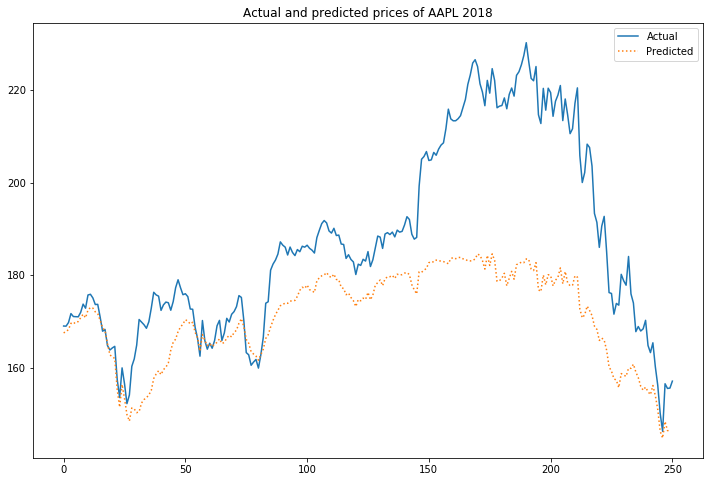

In [38]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title('Actual and predicted prices of AAPL 2018')
plt.plot(actual, label='Actual')
plt.plot(predictions, linestyle='dotted', label='Predicted')
plt.legend();

# Credit card payment default prediction with Keras

## Obtaining the dataset

In [39]:
import pandas as pd

df = pd.read_csv('files/chapter11/default_cc_clients.csv')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

In [41]:
df.head(1)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1


## Splitting and scaling the data

In [42]:
feature_columns= df.columns[:-1]
features = df.loc[:, feature_columns]
target = df.loc[:, 'default payment next month']

In [43]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = \
    train_test_split(features, target, test_size=0.20, random_state=0)

In [44]:
import numpy as np

train_x, train_y = np.array(train_features), np.array(train_target)
test_x, test_y = np.array(test_features), np.array(test_target)

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled_x = scaler.fit_transform(train_x)
test_scaled_x = scaler.transform(test_x)

c:\python3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Designing a deep neural network with 5 hidden layers using Keras

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

num_features = train_scaled_x.shape[1]

model = Sequential()
model.add(Dense(80, input_dim=num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                1920      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                3240      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total para

In [48]:
import tensorflow as tf

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
from keras.callbacks import History 

callback_history = History()

model.fit(
    train_scaled_x, train_y,
    validation_split=0.2,
    epochs=100, 
    callbacks=[callback_history]
)

Train on 19200 samples, validate on 4800 samples
Epoch 1/100
19200/19200 [==============================] - 3s 160us/step - loss: 0.5077 - acc: 0.7770 - val_loss: 0.4662 - val_acc: 0.8033
Epoch 2/100
19200/19200 [==============================] - 2s 99us/step - loss: 0.4666 - acc: 0.8049 - val_loss: 0.4646 - val_acc: 0.8058
Epoch 3/100
19200/19200 [==============================] - 2s 106us/step - loss: 0.4579 - acc: 0.8076 - val_loss: 0.4626 - val_acc: 0.8040
Epoch 4/100
19200/19200 [==============================] - 2s 105us/step - loss: 0.4544 - acc: 0.8088 - val_loss: 0.4536 - val_acc: 0.8083
Epoch 5/100
19200/19200 [==============================] - 2s 115us/step - loss: 0.4527 - acc: 0.8116 - val_loss: 0.4531 - val_acc: 0.8067
Epoch 6/100
19200/19200 [==============================] - 2s 106us/step - loss: 0.4498 - acc: 0.8127 - val_loss: 0.4540 - val_acc: 0.8123
Epoch 7/100
19200/19200 [==============================] - 2s 123us/step - loss: 0.4474 - acc: 0.8133 - val_loss: 0.45

## Measuring the performance of our model

In [51]:
test_loss, test_acc = model.evaluate(test_scaled_x, test_y)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

6000/6000 [==============================] - 0s 37us/step
Test loss: 0.428537715912
Test accuracy: 0.827


### Running risk metrics

In [54]:
predictions = model.predict(test_scaled_x)
pred_values = predictions.round().ravel()

In [55]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_y, pred_values)

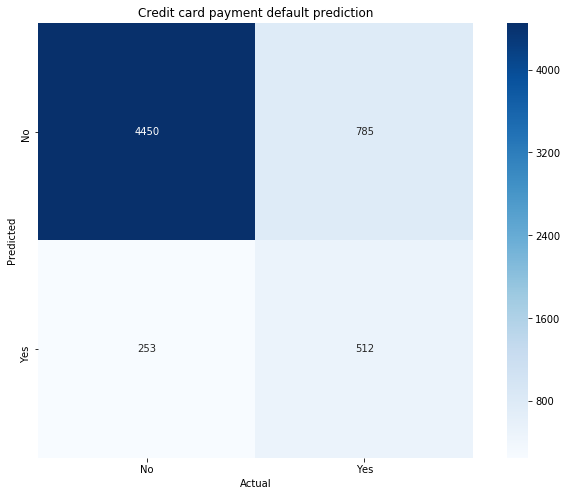

In [56]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

flags = ['No', 'Yes']
plt.subplots(figsize=(12,8))
sns.heatmap(matrix.T, square=True, annot=True, fmt='g', cbar=True, 
    cmap=plt.cm.Blues, xticklabels=flags, yticklabels=flags)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Credit card payment default prediction');

In [58]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
actual, predicted = test_y, pred_values
print('accuracy_score:', accuracy_score(actual, predicted))
print('precision_score:', precision_score(actual, predicted))
print('recall_score:', recall_score(actual, predicted))
print('f1_score:', f1_score(actual, predicted))    

accuracy_score: 0.827
precision_score: 0.669281045752
recall_score: 0.394757131843
f1_score: 0.496605237633


### Displaying recorded events in Keras History

In [59]:
train_acc = callback_history.history['acc']
val_acc = callback_history.history['val_acc']
train_loss = callback_history.history['loss']
val_loss = callback_history.history['val_loss']

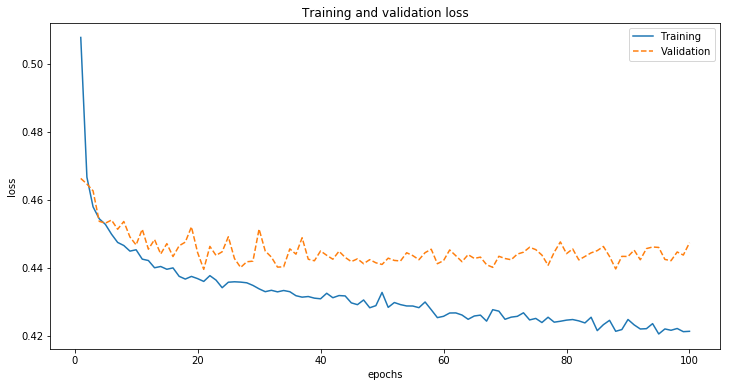

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc)+1)

plt.figure(figsize=(12,6))
plt.plot(epochs, train_loss, label='Training')
plt.plot(epochs, val_loss, '--', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

<Figure size 432x288 with 0 Axes>

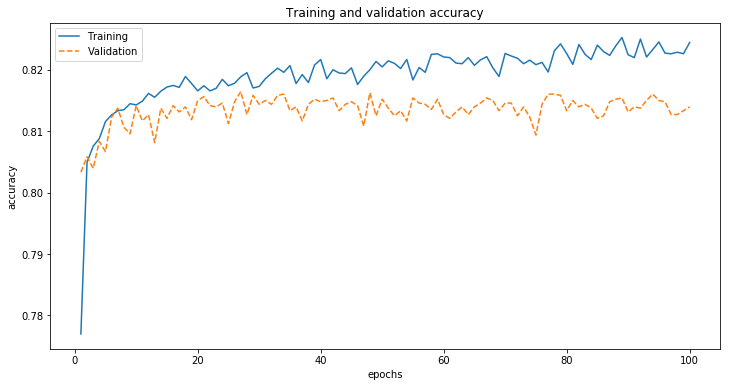

In [62]:
plt.clf()  # Clear the figure
plt.figure(figsize=(12,6))
plt.plot(epochs, train_acc, '-', label='Training')
plt.plot(epochs, val_acc, '--', label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();